# <a name="0">Danqin Shang - Time Series Forecasting</a>

### Forecasting 8 week's of ECOBICI's bicycle usage based on data from the previous 9 months.

 * **ECOBICI**: Mexico's City public bike sharing system
 
 * **Training data**: from 2018-02-05 until 2018-10-07
 * **Forecast horizon**: from 2018-10-08 until 2018-12-02

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

In [2]:
params = {
    "legend.fontsize": "x-large",
    "figure.titlesize": "xx-large",
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
    "figure.figsize": (14, 5),
    "legend.loc": "lower left",
}
plt.rcParams.update(params)

#### Import Data

In [3]:
df = pd.read_csv('C:...\\EcoBici_2018_training_data.csv')

#### Explore Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 2 columns):
Return_date    245 non-null object
usage_count    245 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.9+ KB


In [5]:
df.Return_date = pd.to_datetime(df.Return_date)

In [6]:
df.set_index('Return_date', inplace=True)

In [7]:
df.head()

,usage_count
Return_date,
2018-02-05,9927
2018-02-06,30540
2018-02-07,31577
2018-02-08,29632
2018-02-09,25651


In [8]:
train = df.usage_count["2018-02-05":"2018-09-05"]
val = df.usage_count["2018-09-06":]

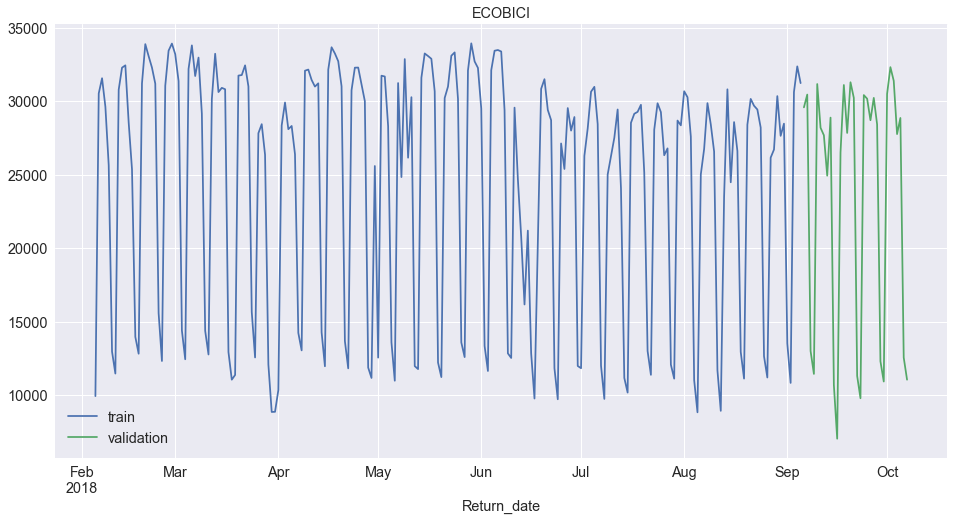

In [9]:
train.plot(figsize=(16,8),title="ECOBICI", label="train")
val.plot(label="validation")
plt.legend()
plt.show()

#### Decomposition

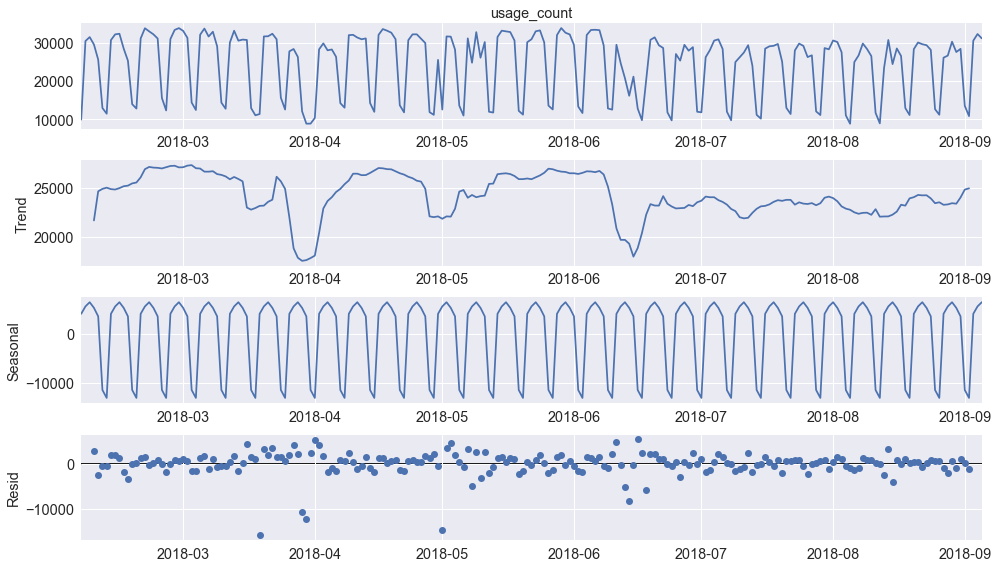

In [10]:
plt.rcParams["figure.figsize"] = (14, 8)
decompose = sm.tsa.seasonal_decompose(train, model="additive")
decompose.plot()
plt.show()

#### Stationary Test

In [11]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [12]:
def adfuller_test(ts, p=0.05, maxlag=None, regression="c"):
    # Run test
    result = adfuller(ts, maxlag=maxlag, regression=regression)
    labels = [
        "ADF test statistics",
        "P-value",
        "# Lags used",
        "# Observations used",
    ]
    print(f"Running ADF test with p-threshold {p}\n")
    for value, label in zip(result, labels):
        print(f"{label}: {str(value)}")
    print()
    if result[1] <= p:
        print("Reject the ADF null hypothesis. Time series is STATIONARY.")
    else:
        print("Cannot reject the ADF null hypothesis. Time series is NON-STATIONARY. ")

In [13]:
def kpss_test(ts, p=0.05, nlags="auto"):
    # Run test
    result = kpss(ts)
    labels = ["KPSS test statistics", "P-value", "# Lags used"]
    print(f"Running KPSS test with p-threshold {p}\n")
    for value, label in zip(result, labels):
        print(f"{label}: {str(value)}")
    print()
    if result[1] <= p:
        print("Reject the KPSS null hypothesis. Time series is NON-STATIONARY. ")
    else:
        print("Cannot reject the KPSS null hypothesis. Time series is STATIONARY.")

In [14]:
adfuller_test(train)

Running ADF test with p-threshold 0.05

ADF test statistics: -3.1508434580638416
P-value: 0.023012276735910654
# Lags used: 15
# Observations used: 197

Reject the ADF null hypothesis. Time series is STATIONARY.


In [15]:
kpss_test(train)

Running KPSS test with p-threshold 0.05

KPSS test statistics: 0.21002668572060582
P-value: 0.1
# Lags used: 15

Cannot reject the KPSS null hypothesis. Time series is STATIONARY.


In [16]:
def acf_pacf_plot(y):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sm.graphics.tsa.plot_acf(y, lags=40, ax=ax[0])
    sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax[1])
    sns.despine()
    fig.tight_layout()
    return fig, ax

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025EDCE052B0>,
       dtype=object))

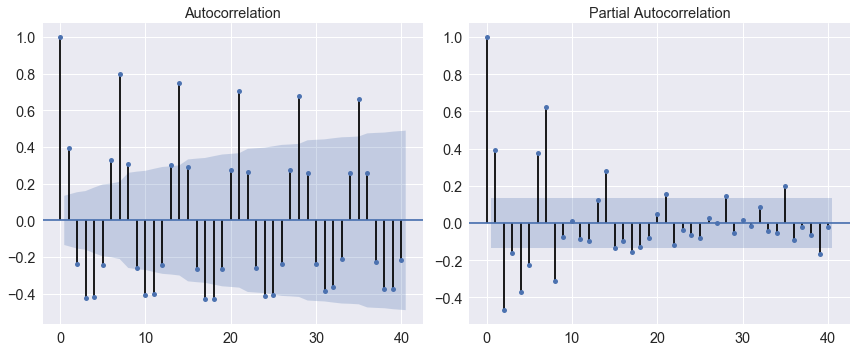

In [17]:
acf_pacf_plot(train)


#### Make it stationary

In [18]:
train_d1 = train.diff(7).dropna()

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025EDD010DA0>,
       dtype=object))

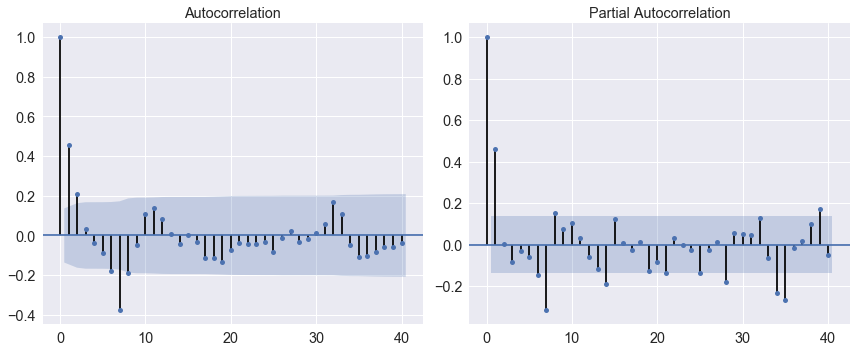

In [19]:
acf_pacf_plot(train_d1)

#### SARIMA

In [20]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [21]:
sarima = sm.tsa.statespace.SARIMAX(
    train, order=(0, 0, 2), seasonal_order=(0, 1, 1, 7)
).fit()

In [22]:
sarima_get_pred = sarima.get_prediction(
    start=val.index.min().date(), end=val.index.max().date()
)
sarima_pred = sarima_get_pred.predicted_mean
sarima_pred.name = "SARIMA selected model"
# In the ETS models it's pred_int. In SARIMA it's called conf_int
sarima_pred_int_95 = sarima_get_pred.conf_int(alpha=0.05)
sarima_pred_int_80 = sarima_get_pred.conf_int(alpha=0.20)

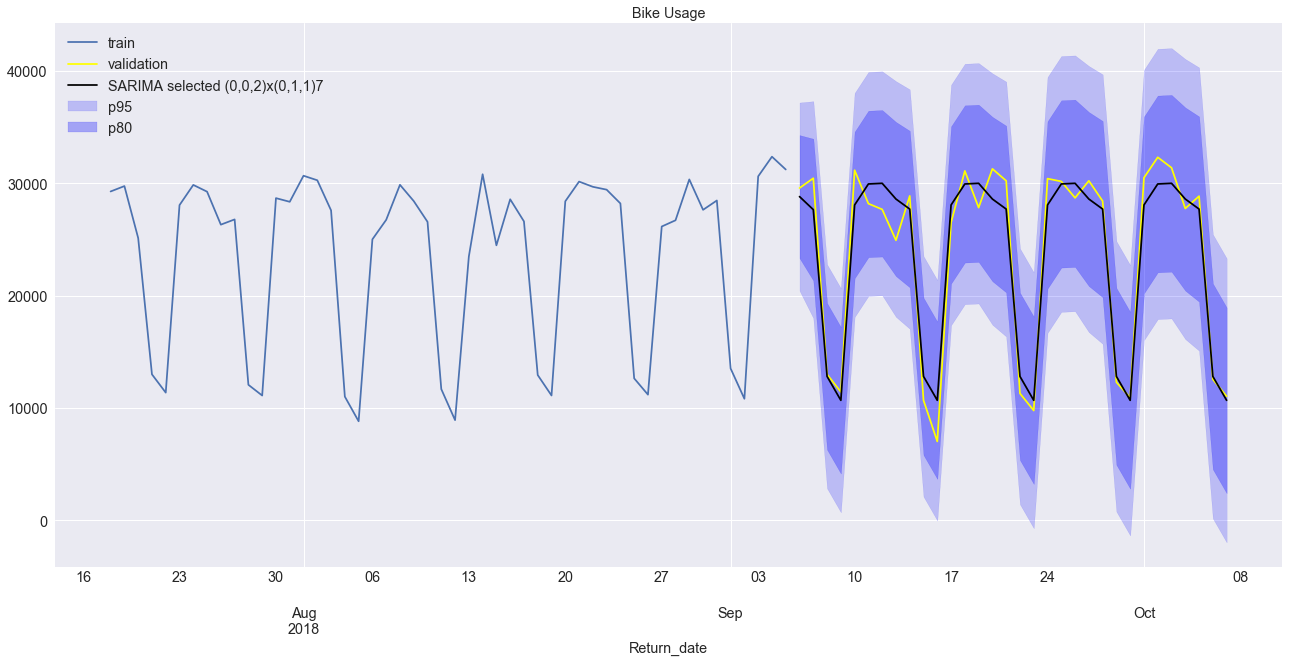

In [23]:
train[-50:].plot(figsize=(22, 10), title="Bike Usage", label="train")
val.plot(figsize=(22, 10), label="validation", color='yellow')
sarima_pred.plot(label="SARIMA selected (0,0,2)x(0,1,1)7", color="black")
plt.fill_between(
    val.index,
    sarima_pred_int_95.iloc[:, 0],
    sarima_pred_int_95.iloc[:, 1],
    color="b",
    alpha=0.2,
    label="p95",
)
plt.fill_between(
    val.index,
    sarima_pred_int_80.iloc[:, 0],
    sarima_pred_int_80.iloc[:, 1],
    color="b",
    alpha=0.3,
    label="p80",
)
plt.legend(loc="upper left")
plt.show()

#### Auto SARIMA

In [24]:
import pmdarima as pmd

In [25]:
autoarima = pmd.auto_arima(
    train,
    seasonal=True,
     m=7,
    n_jobs=-1, # as many as possible
    suppress_warnings=True,
)

In [26]:
autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  213
Model:             SARIMAX(5, 0, 2)x(2, 0, [1], 7)   Log Likelihood               -2096.676
Date:                             Thu, 02 Jun 2022   AIC                           4217.352
Time:                                     13:50:31   BIC                           4257.687
Sample:                                          0   HQIC                          4233.652
                                             - 213                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.467e+04   1.44e+04      1.713      0.087   -3562.748    5.29e+04
ar.L1         -1.3251      0.115    -11.545      0.000      -1.550      -1.100
ar.L2         -0.1819      0.198     -0.918      0.359      -0.570       0.206
ar.L3          0.1853      0.259      0.715      0.475      -0.323       0.693
ar.L4         -0.2755      0.226     -1.217      0.224      -0.719       0.168
ar.L5         -0.1231      0.122     -1.006      0.315      -0.363       0.117
ma.L1          1.8236      0.077     23.533      0.000       1.672       1.975
ma.L2          0.9783      0.076     12.893      0.000       0.830       1.127
ar.S.L7       -0.0019      0.393     -0.005      0.996      -0.772       0.769
ar.S.L14       0.6357      0.306      2.074      0.038       0.035       1.236
ma.S.L7        0.7005      0.436      1.607      0.108      -0.154       1.555
sigma2      3.162e+07     18.335   1.72e+06      0.000    3.16e+07    3.16e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               119.61
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.15e+21. Standard errors may be unstable.
"""

In [33]:
sarima_autoarima = SARIMAX(
    train, order=autoarima.order, seasonal_order=autoarima.seasonal_order
).fit()


In [34]:
sarima_autoarima_get_pred = sarima_autoarima.get_prediction(
    start=val.index.min().date(), end=val.index.max().date()
)
sarima_autoarima_pred = sarima_autoarima_get_pred.predicted_mean
sarima_autoarima_pred.name = "SARIMA Autoarima"

In [38]:
sarima_autoarima_pred_int_95 = sarima_autoarima.get_forecast(len(val)).conf_int(
    alpha=0.05
)
sarima_autoarima_pred_int_80 = sarima_autoarima.get_forecast(len(val)).conf_int(
    alpha=0.20
)

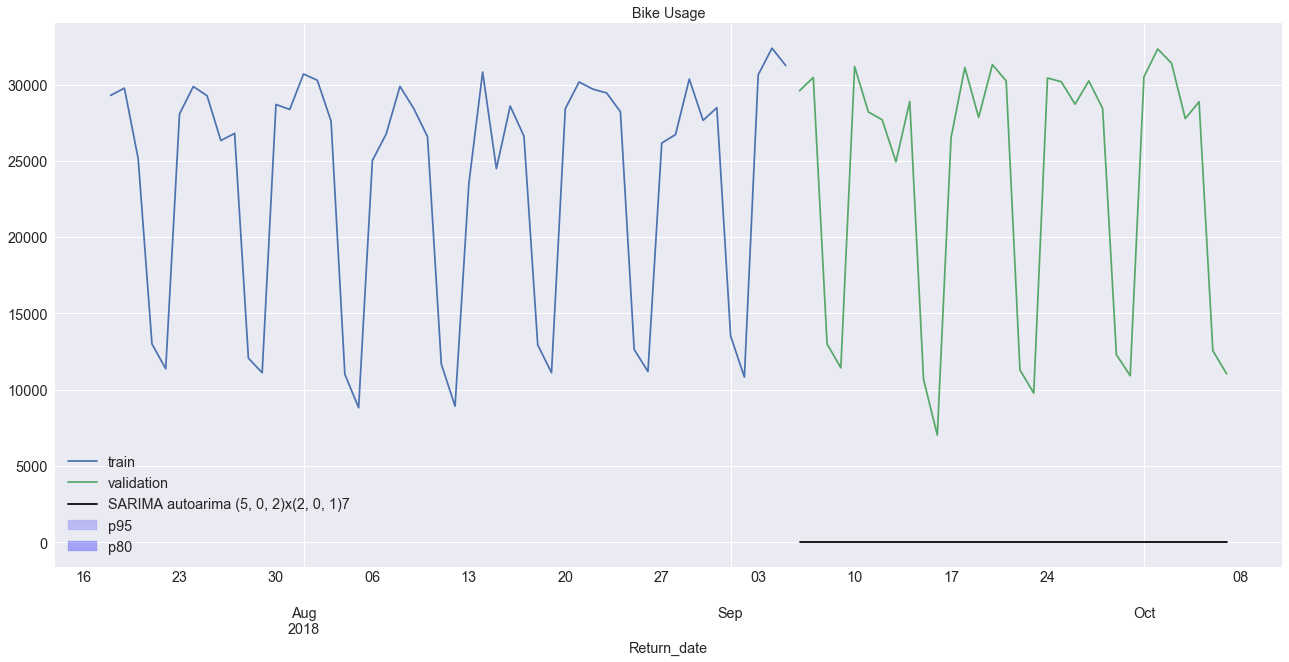

In [39]:
train[-50:].plot(figsize=(22, 10), title="Bike Usage", label="train")
val.plot(label="validation")
sarima_autoarima_pred.plot(label="SARIMA autoarima (5, 0, 2)x(2, 0, 1)7", color="black")
plt.fill_between(
    val.index,
    sarima_autoarima_pred_int_95.iloc[:, 0],
    sarima_autoarima_pred_int_95.iloc[:, 1],
    color="b",
    alpha=0.2,
    label="p95",
)
plt.fill_between(
    val.index,
    sarima_autoarima_pred_int_80.iloc[:, 0],
    sarima_autoarima_pred_int_80.iloc[:, 1],
    color="b",
    alpha=0.3,
    label="p80",
)
plt.legend(loc="best")
plt.show()

#### Check Metrics

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


In [29]:
def symmetric_mape(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 2 * np.mean(diff)

In [30]:
def compute_metrics(actual_ts, forecast):
    mae = mean_absolute_error(actual_ts, forecast)
    mse = mean_squared_error(actual_ts, forecast)
    rms = np.sqrt(mse)
    mape = 100 * mean_absolute_percentage_error(actual_ts, forecast)
    smape = 100 * symmetric_mape(actual_ts, forecast)
    return {"MAE": mae, "MSE": mse, "RMSE": rms, "MAPE": mape, "SMAPE": smape}

In [40]:
forecasts = [sarima_pred, sarima_autoarima_pred]
forecasts_names = [f.name for f in forecasts]

val_metrics = [compute_metrics(val, forecast) for forecast in forecasts]
val_metrics = pd.DataFrame(val_metrics, index=forecasts_names)

print("Validation Metrics")
val_metrics

Validation Metrics


,MAE,MAPE,MSE,RMSE,SMAPE
SARIMA selected model,1580.796959,7.855351,3.482167e+06,1866.056446,7.462107
SARIMA Autoarima,23653.843750,100.000000,6.351342e+08,25201.869835,200.000000


#### Prediction

In [41]:
num_forecast_weeks = 8
test_index = pd.date_range("2018-10-08", freq="D", periods=num_forecast_weeks * 7)

prediction= sarima.get_prediction(start=test_index.min().date(), end=test_index.max().date())
prediction_values = prediction.predicted_mean

forecast = pd.Series(index=test_index, data=prediction_values, name="usage_count")

# Export csv file
forecast.to_csv("bike_usage_prediction.csv")